In [15]:
%matplotlib inline

# notes: all the steps are precomputed with the default parameters below;
#        as a consequence, all the steps but the first one are optional
#        as long as 2.a. is not run

In [16]:
# step 1. initialize

from math import *
import os.path
from tramway.helper import *
import time

## script main parameters ##

trajectory_file = 'glycine_receptor.trxyt'
tessellation_method = 'kmeans'
# average number of locations per cell
location_count = 500
# minimum number of locations per cell
min_location_count = 50

# in the same unit as in the trajectory file (here in micrometers)
localization_error = 0.03
diffusivity_smoothing = 1
potential_smoothing = 1
jeffreys_prior = False
# keep it low otherwise the inference will take days
max_iter = 100

curl_radius = 1

############################

rwa_file = os.path.splitext(trajectory_file)[0]+'.rwa'
mesh_label = '{}_{:d}_min_{:d}'.format(tessellation_method, location_count, min_location_count)
maps_label = 'sigma_{}_d_{}_v_{}_j_{:d}'.format(round(localization_error*1e3), diffusivity_smoothing, potential_smoothing, int(jeffreys_prior))
curl_label = 'curl_{}'.format(curl_radius)


In [3]:
# step 2.a. tessellate
# note: choose either 2.a. or 2.b.; run this cell if the .rwa file does not exist or is to be overwritten

if os.path.exists(rwa_file):
    print('file {} will be overwritten'.format(rwa_file))
tessellate(trajectory_file, tessellation_method,
    avg_location_count=location_count, strict_min_location_count=min_location_count,
    output_file=rwa_file, output_label=mesh_label, force=True)


file glycine_receptor.rwa will be overwritten


In [5]:
# step 2.b. tessellate
# note: choose either 2.a. or 2.b.; run this cell if the .rwa file already exists and a new mesh is to be added

tessellate(rwa_file, tessellation_method,
    avg_location_count=location_count, strict_min_location_count=min_location_count,
    output_label=mesh_label)


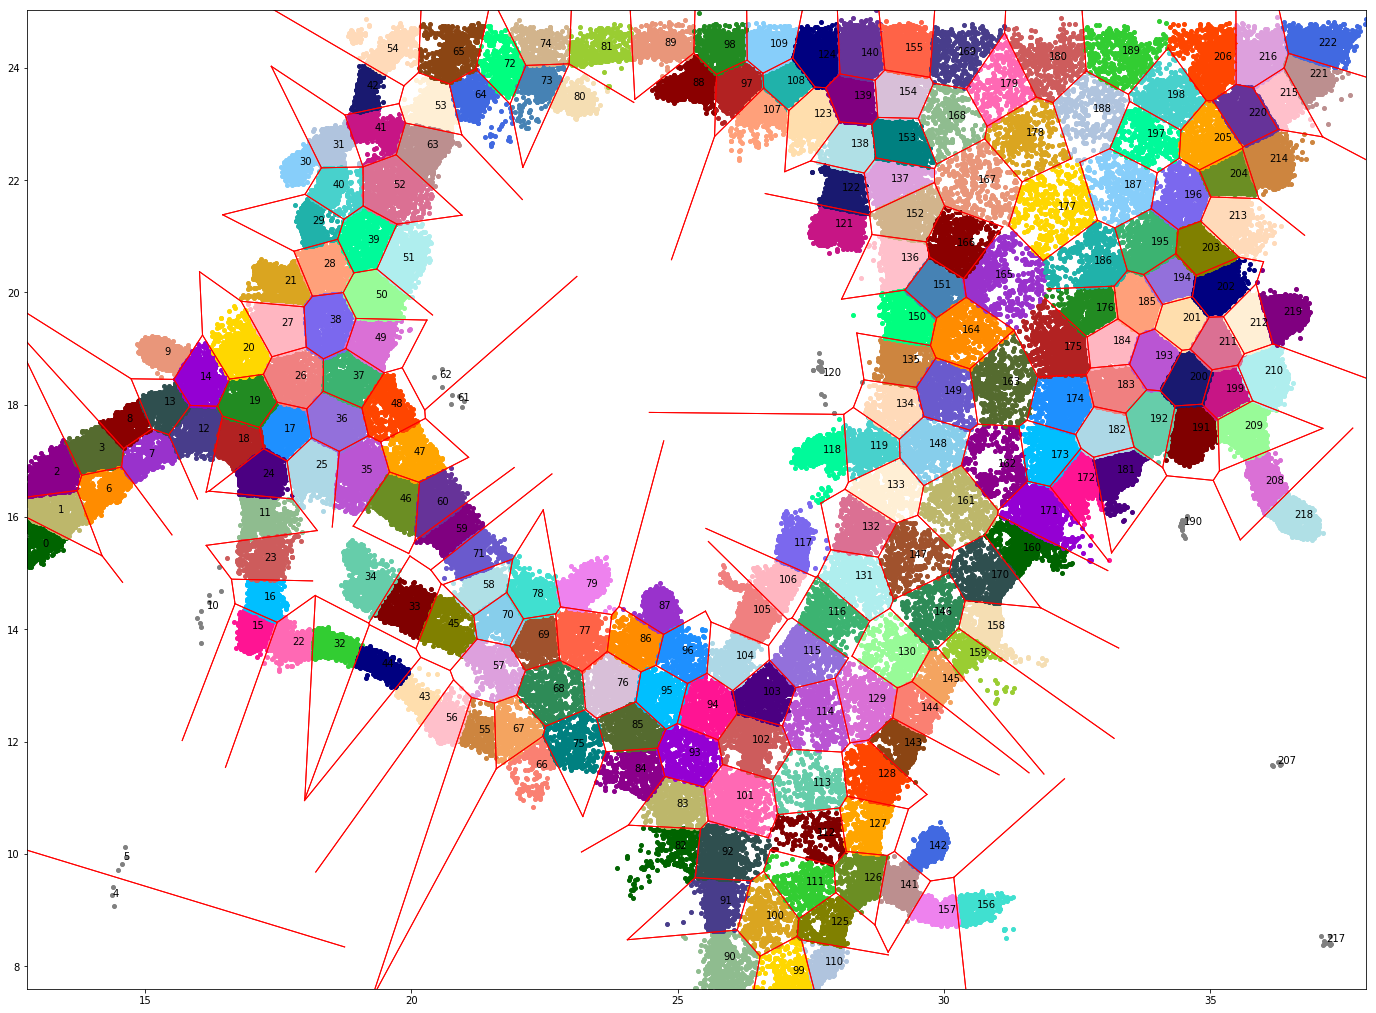

In [6]:
# step 3. plot the mesh
cell_plot(rwa_file, label=mesh_label, cell_indices=True)

# notes: grey points pertain to cells that will be ignored in the inference;
#        red edges denote adjacency;
#        some edges at the border may miss in the figure because of their open end (not a defined point)

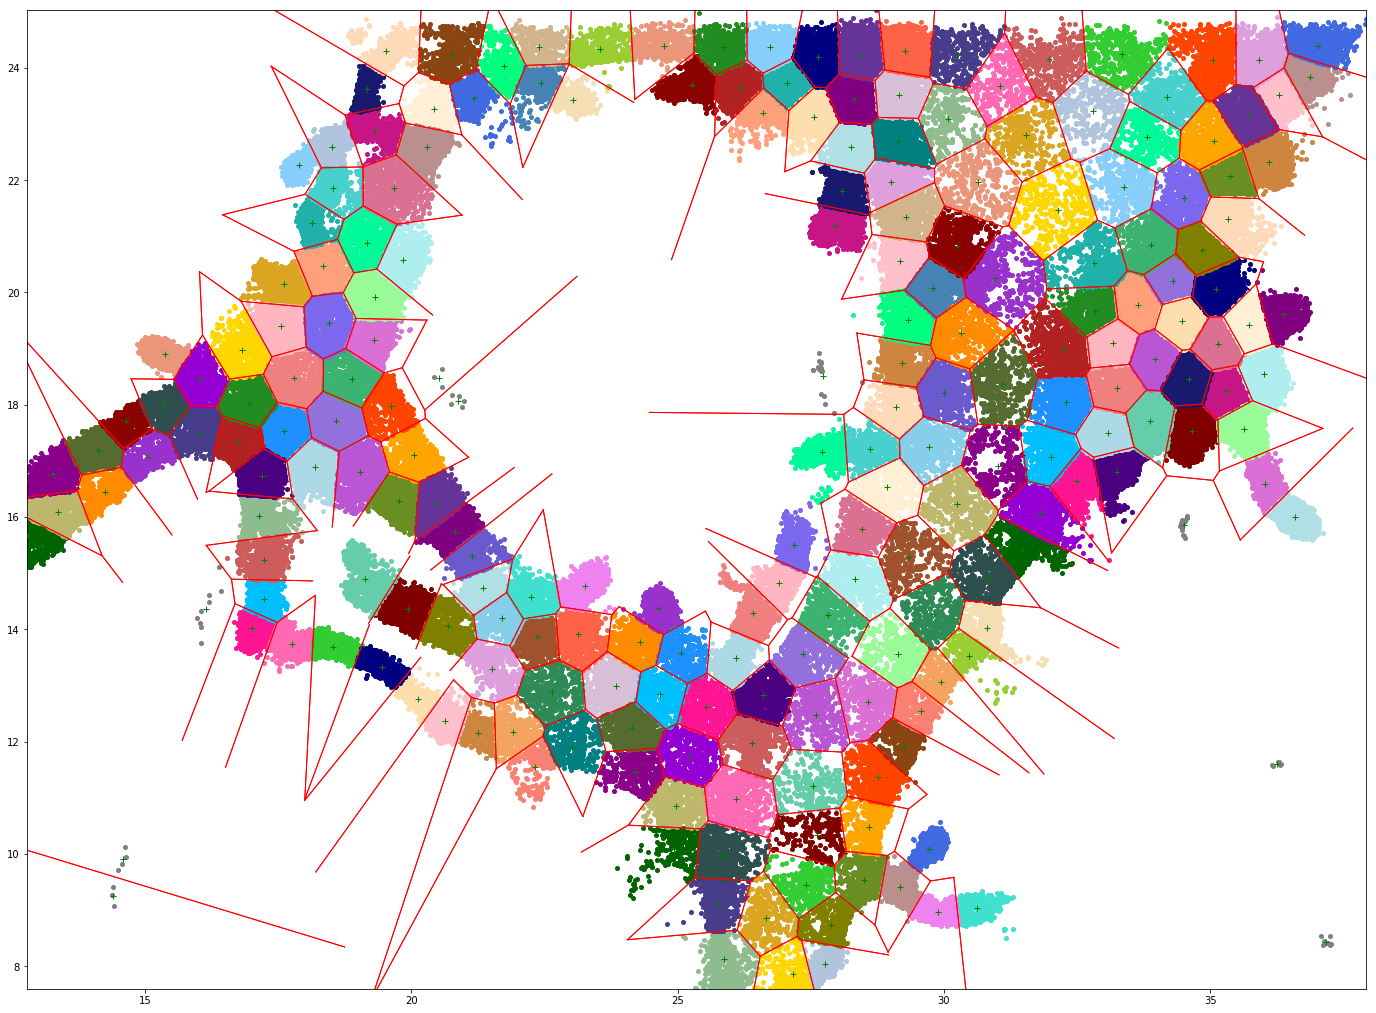

In [8]:
# step 4. edit the mesh

# no helper yet; let us get our hands dirty

# load the mesh
analysis_tree = load_rwa(rwa_file)
mesh = analysis_tree[mesh_label].data.tessellation
adjacency = mesh.adjacency_label

_edge_index = mesh.cell_adjacency
def edge_index(i, j):
    '''protects against implicit zeros in CSR sparse matrices.'''
    js = _edge_index.indices[_edge_index.indptr[i]:_edge_index.indptr[i+1]]
    if j not in js:
        raise IndexError('undefined edge')
    return _edge_index[i, j]

# connect some cells
adjacency[edge_index( 92, 112)] = True
adjacency[edge_index(165, 167)] = True
adjacency[edge_index(165, 175)] = True
adjacency[edge_index(165, 176)] = True
adjacency[edge_index(165, 186)] = True
adjacency[edge_index(177, 188)] = True

# disconnect some other cells
adjacency[edge_index(8, 9)] = False
adjacency[edge_index(32, 33)] = False
adjacency[edge_index(32, 34)] = False
adjacency[edge_index(33, 44)] = False
adjacency[edge_index(33, 59)] = False
adjacency[edge_index(33, 71)] = False
adjacency[edge_index(34, 46)] = False
adjacency[edge_index(43, 45)] = False
adjacency[edge_index(43, 57)] = False
adjacency[edge_index(44, 45)] = False
adjacency[edge_index(79, 87)] = False
adjacency[edge_index(142, 156)] = False
# ...

# save and plot
mesh.adjacency_label = adjacency
save_rwa(rwa_file, analysis_tree, force=True)
cell_plot(analysis_tree, label=mesh_label)


In [11]:
# step 5. infer D and V

t0 = time.time()

infer(rwa_file, 'DV', max_iter=max_iter,
     localization_error=localization_error,
     diffusivity_prior=diffusivity_smoothing,
     potential_prior=potential_smoothing,
     jeffreys_prior=jeffreys_prior,
     input_label=mesh_label, output_label=maps_label)

# take a break

print('elapsed time: {:d}s'.format(round(time.time()-t0)))


elapsed time: 6764s


/home/francois/github/TRamWAy/tramway/inference/dv.py:256: OptimizationWarning: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  warn('{}'.format(result.message), OptimizationWarning)


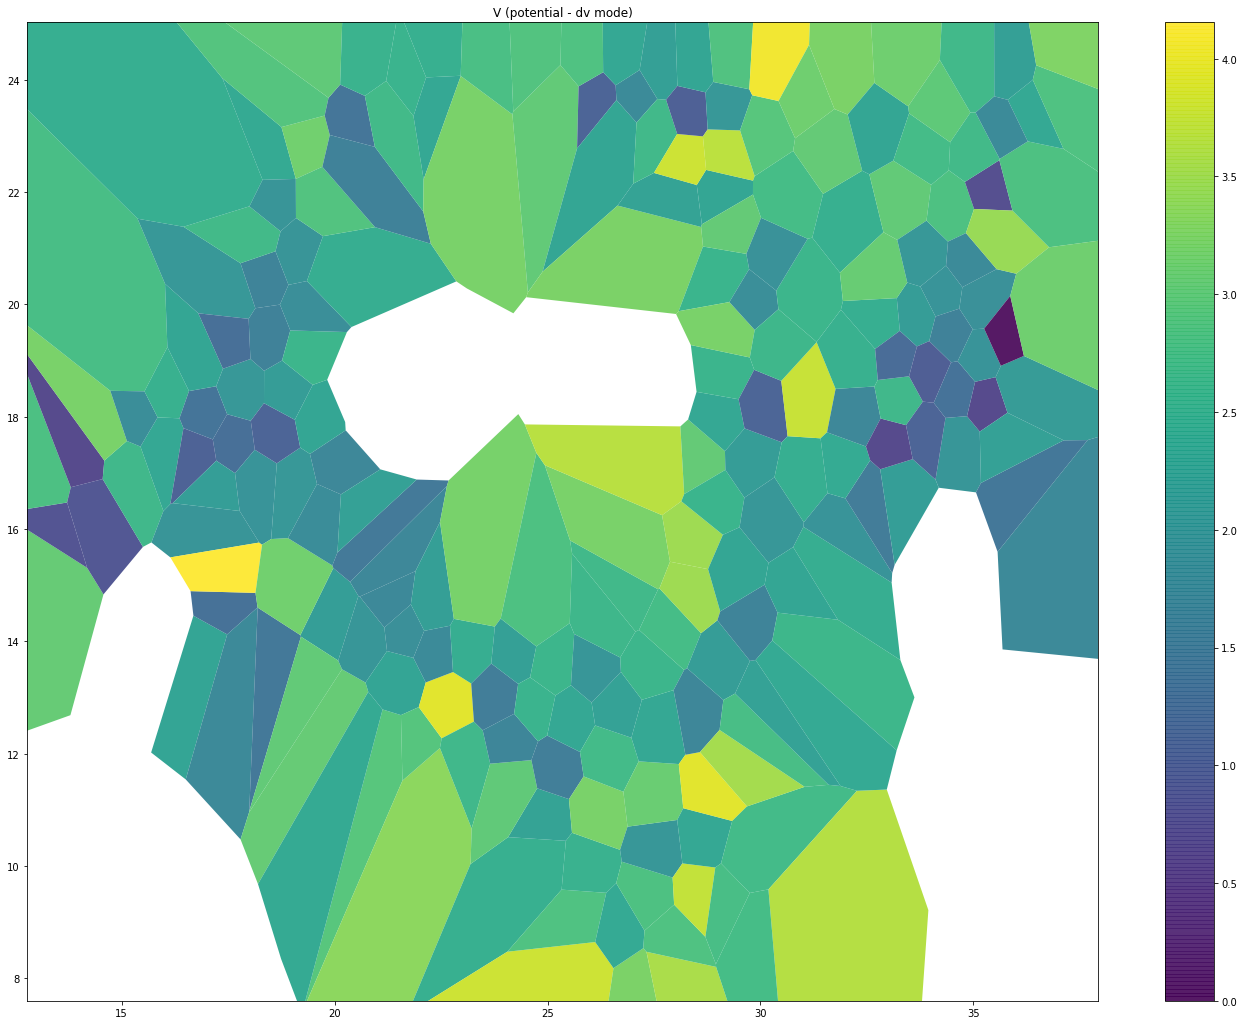

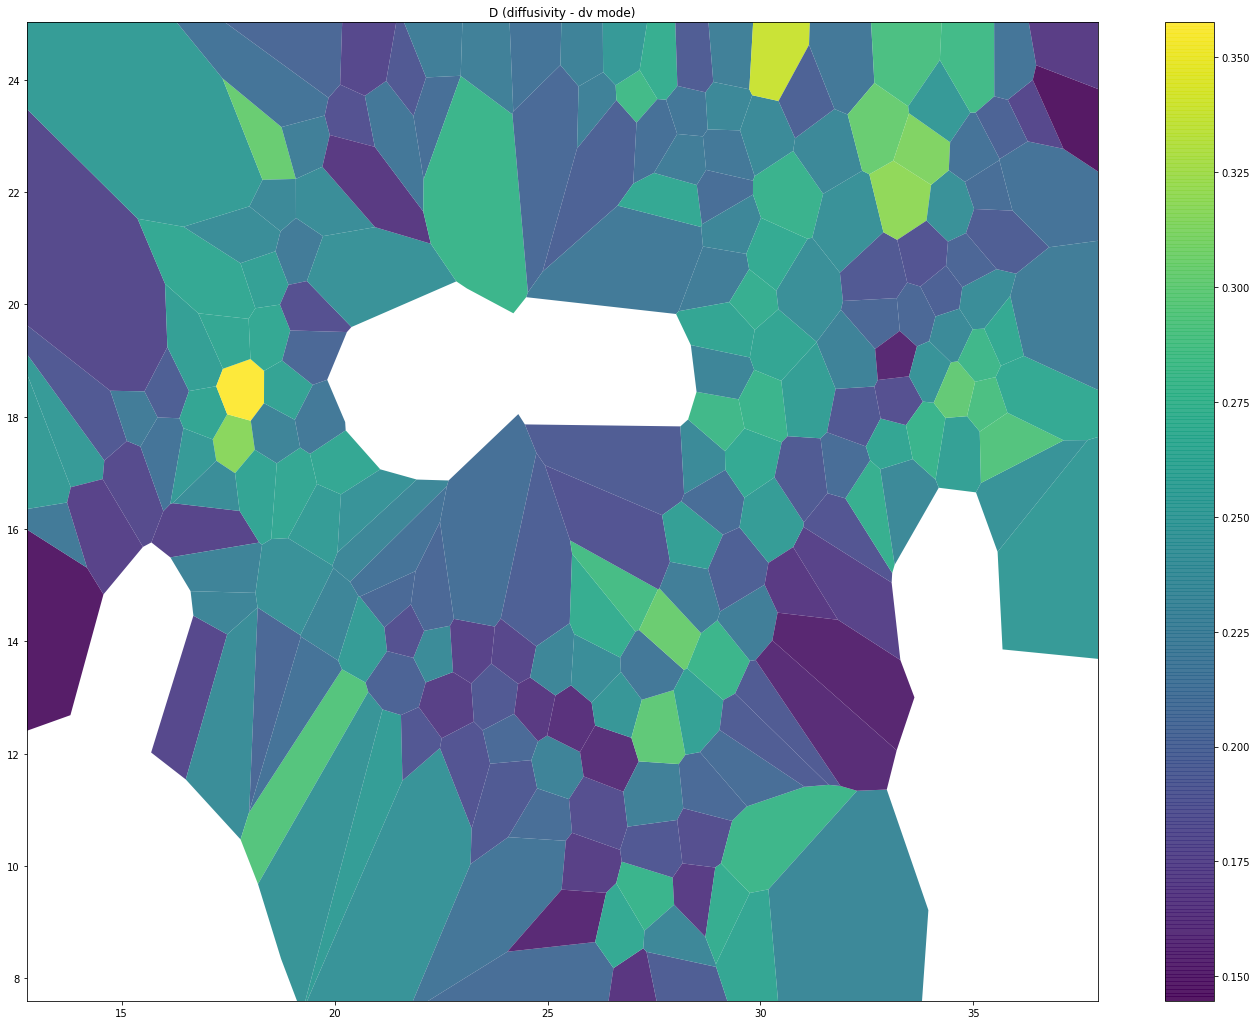

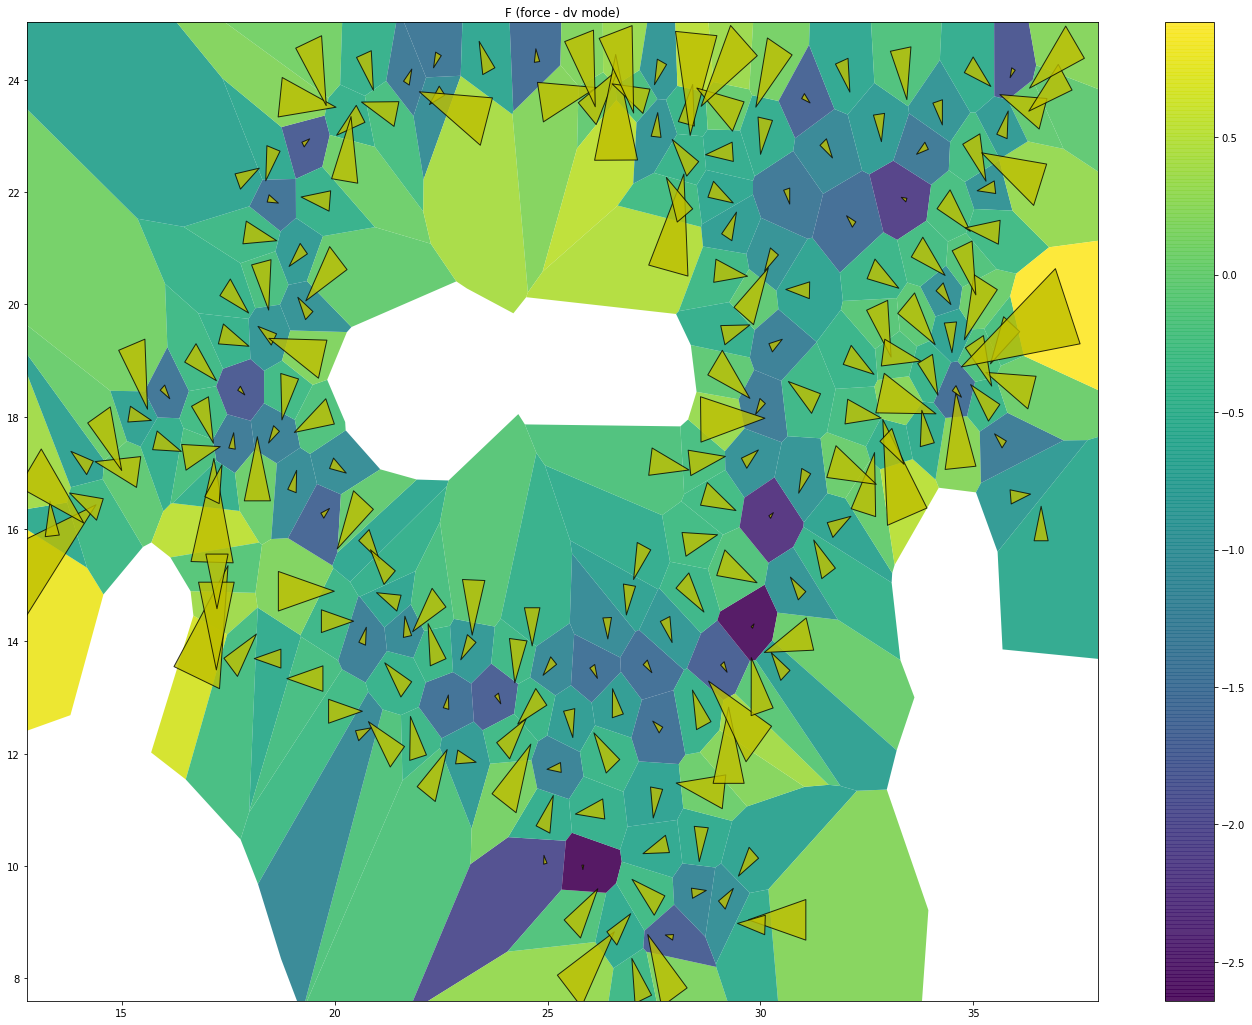

In [13]:
# step 6. plot the maps
map_plot(rwa_file, label=(mesh_label, maps_label))

In [21]:
# step 7. calculate curls

# no helper yet; let us get our hands dirty

from tramway.core import find_artefacts
from tramway.tessellation import CellStats
from tramway.inference import Maps
from tramway.feature.curl import Curl
from copy import copy

# load the tessellation and inferred maps
analysis_tree = load_rwa(rwa_file)
cells, maps, tree_leaf = find_artefacts(analysis_tree, (CellStats, Maps), (mesh_label, maps_label), return_subtree=True)
# make new map with same meta-information as for the inferred maps
curl = copy(maps)
# calculate the curls
curl.maps = Curl(cells, maps).extract(curl_label, 'force', curl_radius)
# save
tree_leaf.add(curl, label=curl_label)
save_rwa(rwa_file, analysis_tree, force=True)

# bonus: "browse" the analysis tree
print(analysis_tree)
#<class 'pandas.core.frame.DataFrame'>                                  <- the trajectory data
#   'kmeans_500_min_50' <class 'tramway.tessellation.base.CellStats'>   <- the mesh and partition of the locations
#       'sigma_30_d_1_v_1_j_0' <class 'tramway.inference.base.Maps'>    <- the inferred maps
#           'curl_1' <class 'tramway.inference.base.Maps'>              <- the curl map


<class 'pandas.core.frame.DataFrame'>
	'kmeans_500_min_50' <class 'tramway.tessellation.base.CellStats'>
		'sigma_30_d_1_v_1_j_0' <class 'tramway.inference.base.Maps'>
			'curl_1' <class 'tramway.inference.base.Maps'>


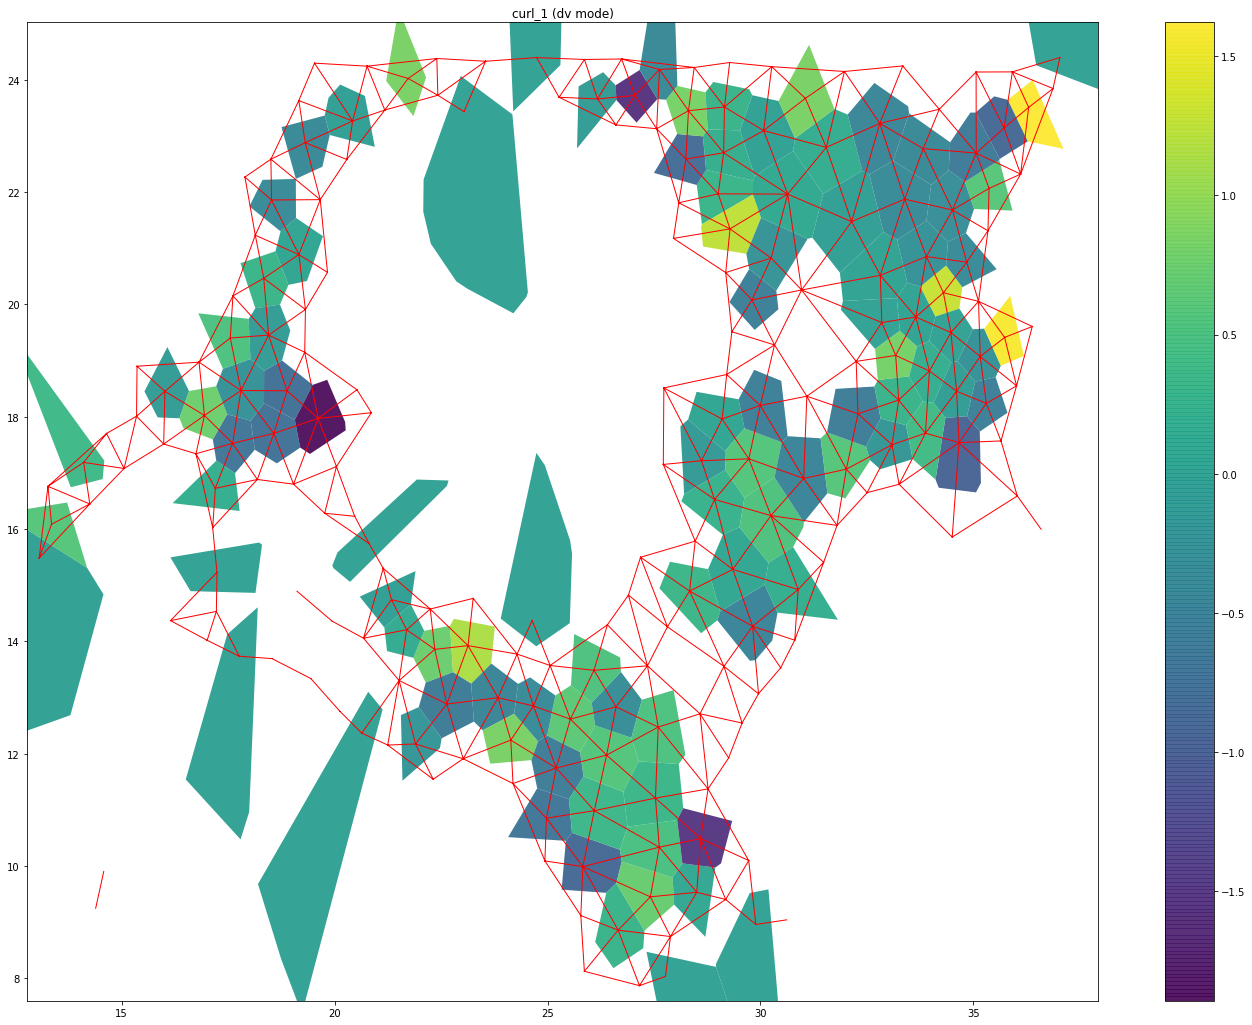

In [26]:
# step 8. plot the curl map
analysis_tree = load_rwa(rwa_file)
map_plot(analysis_tree, label=(mesh_label, maps_label, curl_label), show=False)

# overlay the Delaunay graph to better understand the notes below
from tramway.plot.mesh import plot_delaunay
import matplotlib.pyplot as plt
plot_delaunay(analysis_tree[mesh_label].data, axes=plt.gca(), centroid_style=None)
plt.show()

# notes: many cells may be missing;
#        in most cases, there is no circular path around the missing cell, at the specified radius;
#        this can be appreciated with the Delaunay graph;
#        in the other cases, the circular-path-finding algorithm fails in finding a solution;
#        more importantly, the current algorithm finds solutions where there is not (!),
#        along the border of the Delaunay graph;
#        fortunately, the curl value at these unexpected locations is zero;
#        to be improved...

In [2]:
1000./60.

16.666666666666668